In [1]:
import struct
import numpy as np
import cv2
from IPython.display import display, Image, HTML
import glob

# =============================
#   描画パラメータ
# =============================
XMIN, XMAX = -15, 15
YMIN, YMAX = -15, 15
RES = 800  # 画像解像度

def load_frame(FNAME):
    with open(FNAME, "rb") as f:
        Nx = struct.unpack("q", f.read(8))[0]
        Ny = struct.unpack("q", f.read(8))[0]

        vx_all = np.zeros((Nx,Ny,4))
        vy_all = np.zeros((Nx,Ny,4))
        val_all = np.zeros((Nx,Ny))

        for i in range(Nx):
            for j in range(Ny):
                vx = struct.unpack("4d", f.read(32))
                vy = struct.unpack("4d", f.read(32))
                val = struct.unpack("d",  f.read(8))[0]

                vx_all[i,j] = vx
                vy_all[i,j] = vy
                val_all[i,j] = val

    return vx_all, vy_all, val_all


def world_to_img(x, y):
    ix = int((x - XMIN) / (XMAX - XMIN) * RES)
    iy = int((YMAX - y) / (YMAX - YMIN) * RES)
    return (ix, iy)


def frame_to_image(vx_all, vy_all, val_all):
    # normalize values
    vmin, vmax = val_all.min(), val_all.max()
    print("max:",vmax/0.7769748367466968)
    val_norm = (val_all - vmin) / (vmax - vmin + 1e-12)
    val_norm *= 255

    Nx, Ny = val_all.shape

    img = np.zeros((RES, RES, 3), dtype=np.uint8)

    for i in range(Nx):
        for j in range(Ny):
            pts = np.array([
                world_to_img(vx_all[i,j,k], vy_all[i,j,k])
                for k in range(4)
            ], np.int32)

            color = int(val_norm[i,j])
            cv2.fillPoly(img, [pts], (0,0,color))

    return img




max: 5297573634.597004


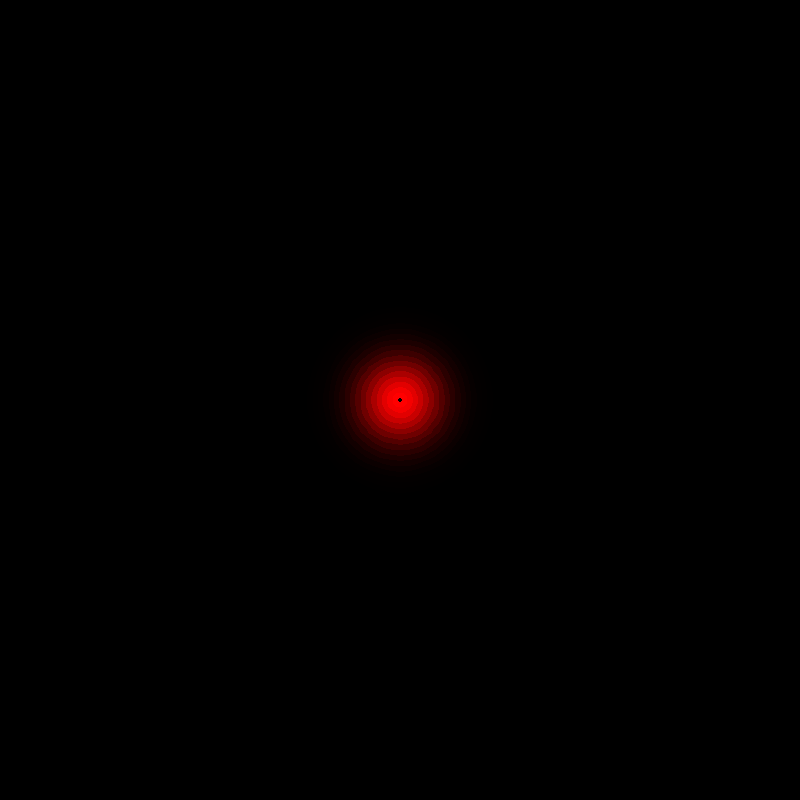

In [2]:
vx, vy, val = load_frame("../output/0D2V_pole/step_0_rank_0.bin")
img = frame_to_image(vx, vy, val)
from IPython.display import Image, display
_, buf = cv2.imencode('.png', img)
display(Image(data=buf))


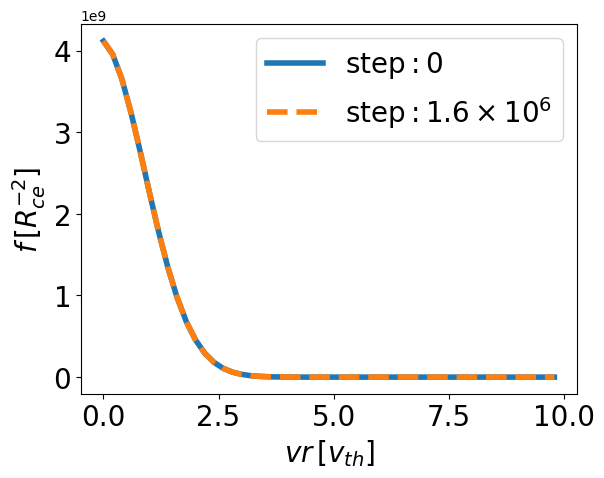

In [7]:
import matplotlib.pyplot as plt
Font_size = 20
_,_,val0 = load_frame("../output/0D2V_pole/step_0_rank_0.bin")
_,_,val100 = load_frame("../output/0D2V_pole/step_100_rank_0.bin")
num_grid_vr = val0.shape[0]
grid_size_vr = 0.2

plt.plot(np.arange(num_grid_vr)*grid_size_vr,
         val100[:,0],
         label = r'$\mathrm{step:}0$',
         lw = 4)
plt.plot(np.arange(num_grid_vr)*grid_size_vr,
         val100[:,0],
         linestyle='--',
         label = r'$\mathrm{step:}1.6\times 10^6$',
         lw = 4)

plt.xlabel(r'$vr\,[v_{th}]$', size=Font_size)
plt.ylabel(r'$f\,[R_{ce}^{-2}]$', size=Font_size)

plt.legend(fontsize=Font_size)   # ← ここを修正
plt.tick_params(axis='both', labelsize=Font_size)
plt.show()

In [ ]:
# =============================
#   アニメーション作成
# =============================

files = sorted(glob.glob("../data/0D2V/*.bin"), key=lambda s: int(s.split('/')[-1].split('.')[0]))
frames = []

for i, fn in enumerate(files):
    print(f"loading {fn} ({i+1}/{len(files)})")
    vx, vy, val = load_frame(fn)
    img = frame_to_image(vx, vy, val)
    frames.append(img)

# GIF 保存
gif_path = "../output/0D2V_10000_cyclotron_50_theta_grid.gif"
fps = 15
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
vid = cv2.VideoWriter("vlasov.mp4", fourcc, fps, (RES, RES))

for frame in frames:
    vid.write(frame)
vid.release()

# GIF生成（imageio必要: pip install imageio）
import imageio
imageio.mimsave(gif_path, [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames], fps=fps)

print("Saved:", gif_path, "and vlasov.mp4")

# Jupyter で GIF 表示
display(HTML(f"<img src='{gif_path}' width=400>"))
